In [1]:
from torch import optim
from time import perf_counter
import sys
import numpy as np

# Function handle that returns an optimizer
def get_optimizer(model, name='adam', lr=0.001, momentum=0.9):
    if name == 'adam':
        return optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    elif name == 'sgd':
        return optim.SGD(model.parameters(), lr=lr,momentum=momentum)
    else:
        print(f'[-] Unknown optimizer {name}')
        sys.exit(-1)

# Function handle that updates the learning rate
# Adapted from https://www.geeksforgeeks.org/adjusting-learning-rate-of-a-neural-network-in-pytorch/
def get_lrs(optimizer, name='ReduceLROnPlateau'):
    if name == "ReduceLROnPlateau":
        return optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, threshold=0.1, cooldown=1)

    elif name == "StepLR":
        return optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    elif name == 'MultiStepLR':
        return optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,30], gamma=0.1)

    else:
        print(f"[-] Unknown scheduler {name}")
        sys.exit(-1)

In [2]:
import os
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights, resnet
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights, mobilenetv3

# Global Variables
local = True
data_path = 'datasets/deeplearningproject/'
if not local:
    data_path = os.path.join('/', data_path)
images_path = os.path.join(data_path, 'train-jpg')
label_path = os.path.join(data_path, 'train_classes.csv')
pruned_label_path = os.path.join(data_path, 'delete_classes.csv')


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


tags = ['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn',
         'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming',
         'selective_logging', 'blow_down']


# network_weights = MobileNet_V3_Small_Weights.DEFAULT
# encoder = mobilenet_v3_small(weights=network_weights)
network_weights = ResNet50_Weights.DEFAULT
encoder = resnet50(weights=network_weights)
preprocess = network_weights.transforms()


loss_function = nn.BCEWithLogitsLoss()
optimizer_name = 'adam'
lrs_name = 'StepLR'


# RNG state used to keep everything reproducible
rng_state = 0


batch_size = 64
epochs = 12
workers = 0

accuracy_threshold = 0.
data_size = 500

In [3]:
# From https://pytorch.org/tutorials/beginner/saving_loading_models.html
def save_model_and_optimizer(path_base, model, optimizer, epoch, loss):
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": loss
    }, path_base+f"_{epoch}.pt")


def load_model_and_optimizer(path, model, optimizer):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    epoch = checkpoint["epoch"]
    loss = checkpoint["loss"]

    return model, optimizer, epoch, loss

In [4]:
def activate_all_grad(model):
    for param in model.parameters():
        param.requires_grad = True


def activate_only_decoder_grad(model):
    for param in model.parameters():
        param.requires_grad = False

    for param in model.classifier.parameters():
        param.requires_grad = True


In [5]:
import torch.nn.functional as F


def Net():
    for param in encoder.parameters():
        param.requires_grad = False

    if isinstance(encoder, mobilenetv3.MobileNetV3):
        decoder = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=576,out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=17)
            
        )
        for param in decoder.parameters():
            param.requires_grad=True

        encoder.classifier = decoder
    elif isinstance(encoder, resnet.ResNet):
        decoder = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=2048,out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=17)
            
        )
        for param in decoder.parameters():
            param.requires_grad=True

        encoder.fc = decoder
    else:
        print(f"[-] Unknown encoder Model: {type(encoder)}")

    return encoder


In [6]:
def accuracy(scores, yb):
    # Binarize predictions via thresholding
    scores[scores>=accuracy_threshold] = 1
    scores[scores<accuracy_threshold] = 0

    return (scores == yb).float().mean()

In [7]:
from sklearn.preprocessing import MultiLabelBinarizer
from time import process_time
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
import torch
import torchvision.transforms as transforms


class MultilabelDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, target_transform=None, preprocessor=None):
        self.img_dataframe = dataframe  # pd.read_csv(annotation_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.preprocessor = preprocessor

        # Encode labels
        split_tags = [row.split(" ") for row in self.img_dataframe["tags"]]
        mlb = MultiLabelBinarizer(classes=tags)
        mlb.fit(split_tags)
        self.img_labels = mlb.transform(split_tags).astype('float32')  # BCELoss does not accept integers *for some reason*

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_dataframe.iloc[idx, 0] + '.jpg')
        pre_time = process_time()
        image = read_image(img_path)
        image = image [:3,:,:]  # remove alpha channel
        loaded_time = process_time()

        if self.preprocessor != None:
            image = image/255  # required for preprocessor | normalize each picture
            image = self.preprocessor(image)
        else:
            image = 2 * (image/255 - 0.5)  # normalize each picture

        processed_time = process_time()
        labels = self.img_labels[idx]

        transform_time = process_time()
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            labels = self.target_transform(labels)

        post_time = process_time()

        # print("load", loaded_time - pre_time, "processing", processed_time - loaded_time, "labels", transform_time - processed_time, "transform", post_time - transform_time)
        # print("total", post_time - pre_time)
        return image, labels

In [8]:
# Taken from Lab code
# Used to part of fit()
def visualize_histories(train_loss_history,
                        valid_loss_history,
                        valid_accuracy_history,
                        class_wise_f2_history,
                        row_wise_f2_mean_history,
                        plot_time_train,
                        plot_time_valid
                        ):
    # Display training and validation losses
    plt.figure()
    lines = []
    labels = []
    l, = plt.plot(plot_time_train, train_loss_history)
    lines.append(l)
    labels.append('Training')
    l, = plt.plot(plot_time_valid, valid_loss_history)
    lines.append(l)
    labels.append('Validation')
    plt.title('Loss')
    plt.legend(lines, labels, loc="upper right", prop=dict(size=14))
    plt.tight_layout()
    plt.show()

    # Display accuracy and average F2 score
    plt.figure()
    lines = []
    labels = []
    l, = plt.plot(plot_time_valid[1:], row_wise_f2_mean_history)
    lines.append(l)
    labels.append('F2')
    l, = plt.plot(plot_time_valid[1:], valid_accuracy_history)
    lines.append(l)
    labels.append('Accuracy')
    plt.title('F2 / Accuracy')
    plt.legend(lines, labels, loc="lower right", prop=dict(size=14))
    plt.show()

    # Display the class-wise F2 scores
    tags = ['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn',
            'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming',
            'selective_logging', 'blow_down']

    if type(class_wise_f2_history) == list:
        class_wise_f2_history = np.array(class_wise_f2_history)

    for i in range(3):
        plt.figure()
        lines = []
        labels = []
        for j in range(6):
            if i == 2 and j == 5:
                continue

            class_idx = 6 * i + j
            class_f2 = class_wise_f2_history[:, class_idx]

            l, = plt.plot(plot_time_valid[1:], class_f2)
            lines.append(l)
            labels.append(tags[class_idx])

        plt.title("Some class-wise F2 scores")
        plt.legend(lines, labels, loc="upper left", prop=dict(size=14))
        plt.show()

In [9]:
def evaluate_model(model, dataLoader):
    with torch.no_grad():
        tp_fp_tn_fn = torch.zeros((4, 17)).to(device)  # For class-wise
        row_wise_fbeta_scores = []
        beta = 2
        n = 0

        for xb, yb in dataLoader:
            xb = xb.to(device)
            yb = yb.to(device)
            n += xb.shape[0]  # Keep a running count of the amount of data points
            yhat = model(xb)

            # Binarize yhat
            yhat[yhat >= 0] = 1
            yhat[yhat < 0] = 0

            # Calculation of true/false positives/negatives
            trues = (yhat == yb)
            falses = (yhat != yb)

            # TP
            batch_tp = torch.logical_and(trues, yhat)
            tp_fp_tn_fn[0, :] += batch_tp.sum(dim=0)
            # FP
            batch_fp = torch.logical_and(falses, yhat)
            tp_fp_tn_fn[1, :] += batch_fp.sum(dim=0)
            # TN
            batch_tn = torch.logical_and(trues, torch.logical_not(yhat))
            tp_fp_tn_fn[2, :] += batch_tn.sum(dim=0)
            # FN
            batch_fn = torch.logical_and(falses, torch.logical_not(yhat))
            tp_fp_tn_fn[3, :] += batch_fn.sum(dim=0)

            batch_row_wise_fbeta_scores = ((1 + beta ** 2) * batch_tp.sum(dim=1)) / ((1 + beta ** 2) * batch_tp.sum(dim=1) + (beta ** 2) * batch_fn.sum(dim=1) + batch_fp.sum(dim=1))
            row_wise_fbeta_scores.extend(batch_row_wise_fbeta_scores.tolist())

        # Accuracy calculation
        accuracy = torch.sum(tp_fp_tn_fn[(0,2), :]) / n  # (TP + TN) / n
        accuracy = accuracy / 17  # Mean over all classes

        # Class-wise f_beta score
        tp, fp, tn, fn = torch.vsplit(tp_fp_tn_fn, 4)
        class_wise_fbeta_scores = ((1 + beta**2) * tp) / ((1 + beta**2) * tp + (beta**2) * fn + fp)

        row_wise_fbeta_score_mean = np.mean(row_wise_fbeta_scores)
        return accuracy.item(), class_wise_fbeta_scores.tolist()[0], row_wise_fbeta_score_mean


In [10]:
from sklearn.model_selection import train_test_split


labels = pd.read_csv(label_path)
labels = labels.sample(frac=1, random_state=rng_state)
train_data, test_daa = train_test_split(labels[:data_size], train_size=0.9, random_state=rng_state)

trainset = MultilabelDataset(
    train_data,
    images_path,
    preprocessor=preprocess
)

testset = MultilabelDataset(
    test_daa,
    images_path,
    preprocessor=preprocess
)

In [11]:
from torch import optim
import matplotlib.pyplot as plt

# Function to fit a model
# Adapted from Lab code
def fit(model,
        opt,
        lr_scheduler,
        loss_func,
        bs=256,
        epochs=1,
        batches_per_epoch=None, # Default: Use entire training set
        show_summary=True,
        workers=0,
        save_path=""):

  # Set up data loaders
  if batches_per_epoch == None:
    # Use all images
    train_dl = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=True, num_workers=workers, persistent_workers=workers)
    valid_dl = torch.utils.data.DataLoader(testset, batch_size=bs,
                                         shuffle=False, num_workers=workers, persistent_workers=workers)
    batches_per_epoch = len(train_dl)
  else:
    # Only use a subset of the data
    subset_indices = list(range(batches_per_epoch*bs))
    train_dl = torch.utils.data.DataLoader(trainset, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices), num_workers=workers, persistent_workers=workers)

    # Use one fourth for validation
    subset_indices = list(range(int(np.ceil(batches_per_epoch/4))*bs))
    valid_dl = torch.utils.data.DataLoader(testset, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices), num_workers=workers, persistent_workers=workers)

  # For book keeping
  train_loss_history = []
  valid_loss_history = []
  plot_time_train = []
  plot_time_valid = []
  valid_acc_history = []
  class_wise_f2_history = []
  row_wise_f2_mean_history = []

  # Index of current batch
  t = 1

  # Total number of batches
  T = batches_per_epoch * epochs
  
  print('Epochs:',epochs,'Batches per epoch:',batches_per_epoch,'Total number of batches',T)
  
  # Get initial validation loss and accuracy
  model.eval()
  with torch.no_grad():
    if torch.cuda.is_available():
        valid_acc = sum(accuracy(model(xb.cuda()), yb.cuda()) for xb, yb in valid_dl) / len(valid_dl)
        valid_loss = sum(loss_func(model(xb.cuda()), yb.cuda()) for xb, yb in valid_dl) / len(valid_dl)
        valid_loss_history.append(valid_loss.detach().cpu().numpy())
        plot_time_valid.append(t)
    else:
        valid_acc = sum(accuracy(model(xb), yb) for xb, yb in valid_dl) / len(valid_dl)
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl) / len(valid_dl)
        valid_loss_history.append(valid_loss.detach().cpu().numpy())
        plot_time_valid.append(t)

  # Train
  pre_training_time = perf_counter()
  for epoch in range(epochs):
    if epoch == 2:
      model.cpu()
      activate_all_grad(model)
      model.cuda()

    model.train() # Train mode    
    for xb, yb in train_dl:
      # Forward prop      
      if torch.cuda.is_available():
        pred = model(xb.cuda())
        loss = loss_func(pred, yb.cuda())
      else:
        pred = model(xb)
        loss = loss_func(pred, yb) 

      # Book keeping
      train_loss_history.append(loss.detach().cpu().numpy())
      plot_time_train.append(t)
      t += 1

      # Backward prop (calculate gradient)
      loss.backward()
      
      # Update model parameters
      opt.step()
      opt.zero_grad()


      # Validation loss and accuracy
      if t % 20 == 0:
        model.eval() # Test mode
        with torch.no_grad():
            if torch.cuda.is_available():
                valid_acc, class_wise_f2, row_wise_f2_mean = evaluate_model(model, valid_dl)
                valid_acc_history.append(valid_acc)
                class_wise_f2_history.append(class_wise_f2)
                row_wise_f2_mean_history.append(row_wise_f2_mean)
                valid_loss = sum(loss_func(model(xb.cuda()), yb.cuda()) for xb, yb in valid_dl) / len(
                    valid_dl)
                valid_loss_history.append(valid_loss.detach().cpu().numpy())
                plot_time_valid.append(t - 1)
                print('t', t, 'lr', opt.param_groups[0]['lr'], 'train loss', loss.detach().cpu().numpy(),
                      'val loss', valid_loss.detach().cpu().numpy(), 'val accuracy',
                      valid_acc, "row-wise f2 mean", row_wise_f2_mean)
            else:
                valid_acc, class_wise_f2, row_wise_f2_mean = evaluate_model(model, valid_dl)
                valid_acc_history.append(valid_acc)
                class_wise_f2_history.append(class_wise_f2)
                row_wise_f2_mean_history.append(row_wise_f2_mean)
                valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl) / len(valid_dl)
                valid_loss_history.append(valid_loss.detach().cpu().numpy())
                plot_time_valid.append(t - 1)
                print('t', t, 'lr', opt.param_groups[0]['lr'], 'train loss', loss.detach().cpu().numpy(),
                      'val loss', valid_loss.detach().cpu().numpy(), 'val accuracy',
                      valid_acc, "row-wise f2 mean", row_wise_f2_mean)
        model.train() # Back to train mode
    
    # Update learning rate once per epoch 
    lr_scheduler.step()

    # PATH = f"{save_path}_{epoch}.pt" if save_path else f"model_{epoch}.pt"
    PATH = save_path + "_.pt"
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": opt.state_dict(),
        "loss": loss.detach().cpu().numpy(),
        "valid_loss_history": valid_loss_history,
        "valid_accuracy_history": valid_acc_history,
        "class_wise_f2_history": class_wise_f2_history,
        "row_wise_f2_mean_history": row_wise_f2_mean_history,
        "train_loss_history": train_loss_history,
        "plot_time_train": plot_time_train,
        "plot_time_valid": plot_time_valid,
    }, PATH)
          
  # Summary
  if show_summary:
    visualize_histories(train_loss_history, valid_loss_history, valid_acc_history, class_wise_f2_history, row_wise_f2_mean_history, plot_time_train, plot_time_valid)

  return train_loss_history

Epochs: 12 Batches per epoch: 8 Total number of batches 96
t 20 lr 0.001 train loss 0.6171106 val loss 0.64781356 val accuracy 0.9117646813392639 row-wise f2 mean 0.6504051584005356
t 40 lr 0.001 train loss 0.3389415 val loss 0.3630793 val accuracy 0.9152941107749939 row-wise f2 mean 0.7158733755350113
t 60 lr 0.001 train loss 0.2570178 val loss 0.3745612 val accuracy 0.9399999976158142 row-wise f2 mean 0.762018414735794
t 80 lr 0.001 train loss 0.22455533 val loss 0.3156215 val accuracy 0.9364705681800842 row-wise f2 mean 0.7526660823822021


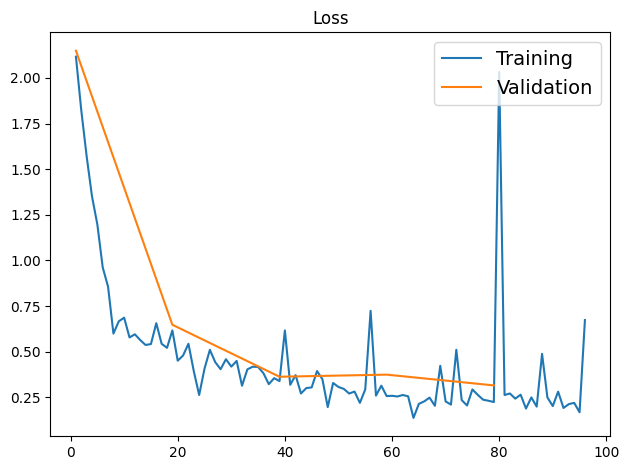

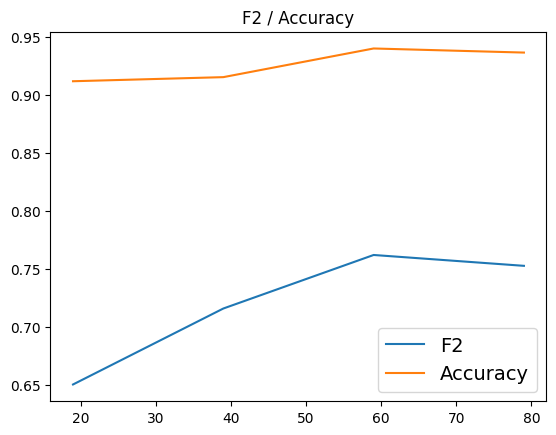

<class 'int'>
<class 'numpy.ndarray'>
<class 'int'>
<class 'numpy.ndarray'>
<class 'int'>
<class 'numpy.ndarray'>
<class 'int'>
<class 'numpy.ndarray'>
<class 'int'>
<class 'numpy.ndarray'>
<class 'int'>
<class 'numpy.ndarray'>


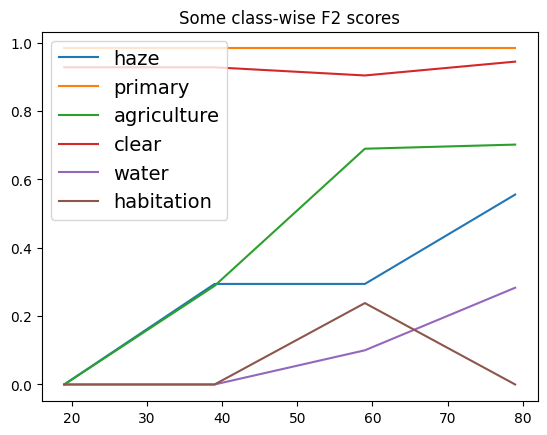

<class 'int'>
<class 'numpy.ndarray'>
<class 'int'>
<class 'numpy.ndarray'>
<class 'int'>
<class 'numpy.ndarray'>
<class 'int'>
<class 'numpy.ndarray'>
<class 'int'>
<class 'numpy.ndarray'>
<class 'int'>
<class 'numpy.ndarray'>


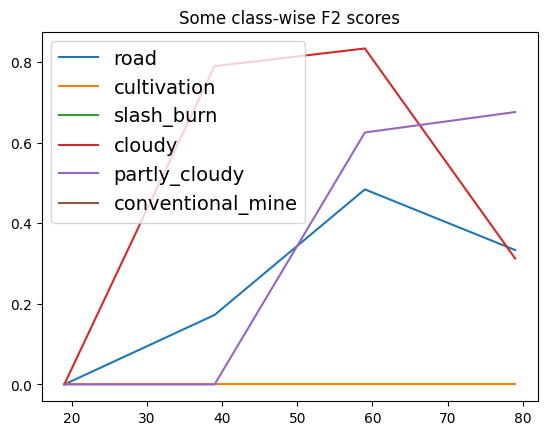

<class 'int'>
<class 'numpy.ndarray'>
<class 'int'>
<class 'numpy.ndarray'>
<class 'int'>
<class 'numpy.ndarray'>
<class 'int'>
<class 'numpy.ndarray'>
<class 'int'>
<class 'numpy.ndarray'>


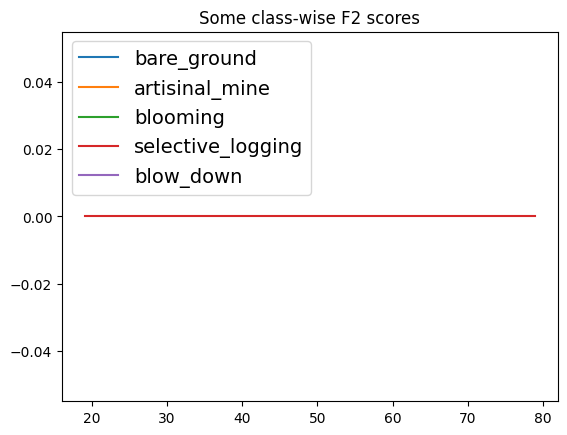

In [12]:
# Adapted from Lab code
model = Net()
if torch.cuda.is_available():
    model = model.cuda()

optimizer = get_optimizer(model, optimizer_name)
lrs = get_lrs(optimizer, lrs_name)

# idf-scores of all the weights
loss_weights = torch.Tensor(
    [
            2.708643276959167,
            0.0760957815487335,
            1.1899652895442587,
            0.35330322196059244,
            1.697817938147538,
            2.4033201737034853,
            1.6125059307745246,
            2.1863156462738864,
            5.266204348134086,
            2.9640978385423313,
            1.7182657607186502,
            6.003368414110806,
            3.849283329435204,
            4.782538492718447,
            4.803403631182408,
            4.77959298248869,
            5.993418083257637
        ]
)
loss_weights = loss_weights.to(device)
loss_function = nn.BCEWithLogitsLoss(weight=loss_weights)

# Train with default settings.
train_loss_history = fit(model, loss_func=loss_function,\
                         opt=optimizer, lr_scheduler=lrs, bs=batch_size, epochs=epochs, workers=workers)

In [13]:
# Redo the dataset for training on the pruned dataset
pruned_labels = pd.read_csv(pruned_label_path)
pruned_labels = pruned_labels.sample(frac=1, random_state=rng_state)

# Take out all the original training images from the pruned set
# This is done so we don't accidentally train on images that we want to test on
pruned_labels = pruned_labels[pruned_labels["image_name"].str.startswith("train")]

_, test_data = train_test_split(labels[:], train_size=0.6, random_state=0)

trainset = MultilabelDataset(
    pruned_labels,
    images_path,
    preprocessor=preprocess
)

testset = MultilabelDataset(
    test_data,
    images_path,
    preprocessor=preprocess
)

In [14]:
# Running the pruned model
# Adapted from Lab code
model = Net()
if torch.cuda.is_available():
    model = model.cuda()

optimizer = get_optimizer(model, optimizer_name)
lrs = get_lrs(optimizer, lrs_name)

loss_function = nn.BCEWithLogitsLoss()

# Train with default settings.
train_loss_history = fit(model, loss_func=loss_function,\
                         opt=optimizer, lr_scheduler=lrs, bs=batch_size, epochs=epochs, workers=workers)

Epochs: 12 Batches per epoch: 45 Total number of batches 540


KeyboardInterrupt: 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=523d2edd-b418-4a9e-989b-f9b1860f5009' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>